# Homework 6
This homework builds on the effective visualization workshop with the Star Trek data. Below is what we completed in class. Output is suppressed for readability, but you can remove the supression on your code if you'd like.

In [58]:
invisible({
suppressPackageStartupMessages(library(tidyverse))

# Get the data.
dialogs <- read_csv(
  "https://raw.githubusercontent.com/Vincent-Toups/bios512/fcbc65a2696c7cff80d0f6ed1dd5c97abf0ef800/effective-visualization/source_data/tng.csv",
  show_col_types = FALSE
)
head(dialogs, 10) # Showing first 10 observations

# Checkout the data.
names(dialogs)
dialogs %>% group_by(character) %>% tally() %>% arrange(desc(n))
dialogs %>% mutate(dialog_length=str_length(dialog)) %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length)) %>% arrange(desc(mean_dialog_length))

# Fix weird data.
dialogs %>% filter(character=="BEVERLY'S")

dialogs_fixed <- dialogs %>%
  mutate(
    character = str_replace_all(character, "'S.*$", ""),
    character = str_replace_all(character, " VOICE", ""),
    character = str_replace_all(character, "\\.", ""),
    character = str_replace_all(character, "'", ""),
    character = str_replace_all(character, "S COM", ""),
    character = str_replace_all(character, " COM", ""),
    dialog_length = str_length(dialog)
  ) %>%
  filter(character %in% unlist(str_split("PICARD RIKER DATA TROI BEVERLY WORF WESLEY GEORDI", " ")))

dialogs_fixed %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length)) %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep <- dialogs_fixed %>% group_by(character, episode_number) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length), .groups = "drop") %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep

# Plot the data.
ggplot(dialogs_fixed) + geom_density(aes(x=dialog_length))

for_factor <- dialog_len_per_ep %>% group_by(character) %>% summarise(m=mean(mean_dialog_length)) %>% arrange(desc(m))
ggplot(dialog_len_per_ep, aes(factor(character,for_factor$character), mean_dialog_length)) + geom_boxplot()

dialog_len_per_ep <- dialogs_fixed %>%
    group_by(character, episode_number) %>%
    summarize(mean_dialog_length = mean(dialog_length), dialog_count=n(), .groups = "drop") %>%
    arrange(desc(mean_dialog_length))

ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + geom_point(aes(color=character)) + facet_wrap(~character)
})

## Question 1
In class, we left off on the plot below, which shows the distribution of dialog count by mean dialog length, where each point represents an episode. Interpret these results. How can we tell the character's role in the story by their plot?

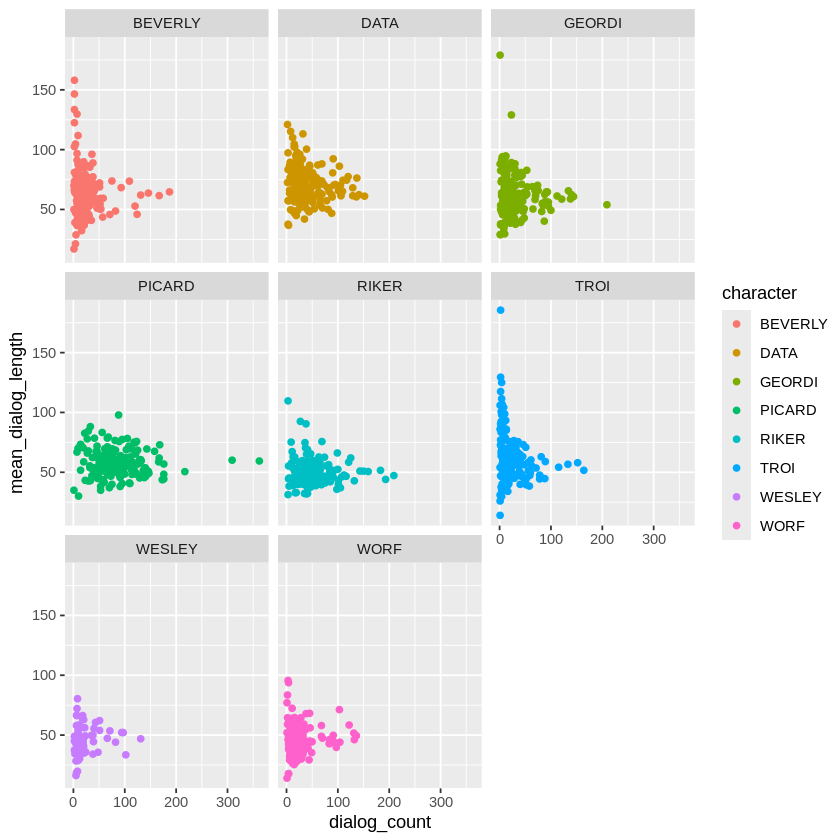

In [59]:
ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) +
    geom_point(aes(color=character)) +
    facet_wrap(~character)

There are a few key things to look at to tell a characters role in the story. First off, a high point means that when a character talks, they are speaking for a long amount of time. For characters who tend to have higher dialogue lengths, this may mean that their words matter heavily to the story. Additionally, we can see that characters with outlying points like Geordi or Troi may have episodes that focus on them, where they have long spans of dialogue.

## Question 2
#### a) Compare Beverly's mean dialog per episode vs. mean dialog count per episode from season 1 (episodes 102-126) to season 3 (episodes 149-174) in a table.  
*Hints*:  
-   First, use `filter()` to get - 1) the dialog from only Beverly's character and 2) the episodes within the ranges given.
-   Then, add a season variable using `mutate()` with `case_when()`.
-   To create the means per episode, after your `mutate()` step, you'll need to `group_by()` season and episode number, then you can do your `summarize()` step to get the means by episode. At the end of the `summary()` statement (inside the parenthesis), add `.groups="drop"`.
-   Then, to get the mean of means, you'll do the same as above, but only grouping by season.

In [60]:
summary(dialogs)

 episode_number   character            dialog         
 Min.   :102.0   Length:76909       Length:76909      
 1st Qu.:144.0   Class :character   Class :character  
 Median :189.0   Mode  :character   Mode  :character  
 Mean   :188.9                                        
 3rd Qu.:233.0                                        
 Max.   :277.0                                        

In [61]:
dialogs_bev <- dialogs |>
  filter(character=="BEVERLY", (episode_number %in% 149:174) | (episode_number %in% 102:126))

dialogs_bev <- dialogs_bev|>
  mutate(season = case_when(
    episode_number %in% 102:126 ~ "Season 1",
    episode_number %in% 149:174 ~ "Season 3"
  ))

episode_means <- dialogs_bev |>
  group_by(season, episode_number) |>
  summarize(mean_dialog_length = mean(str_length(dialog)), .groups = "drop")

season_means <- episode_means |>
  group_by(season) |>
  summarize(season_mean_dialog_length = mean(mean_dialog_length), .groups = "drop")
season_means


season,season_mean_dialog_length
<chr>,<dbl>
Season 1,56.48460
Season 3,67.04817


#### b) In class, we talked about this character saying the actress has stated that after she was fired and rehired, the writers began giving her storylines that made her feel like a male character. How is this reflected in our table?

Her dialogue length increased by about 9 characters. This implies that she had some more substantive lines which brought her dialogue length up.

## Question 3
Let's compare the vocabulary richness (unique words / total words) of each character.
#### a) Tokenize dialog into words, remove punctuation, convert to lowercase. Then filter out the stop words in the list below (from https://gist.github.com/sebleier/554280).
*Hint*: Here's a template for that this step should look like:
```
tokens <- YOUR_DATASET %>%
  # Split each dialog into words
  mutate(word_list = str_split(DIALOG_COLUMN, "\\s+")) %>%
  
  # Unnest the list column so each word is a row
  unnest(word_list) %>%
  
  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%
  
  # Remove empty strings and stopwords
  filter(word != "", !word %in% STOPWORDS)
```

In [62]:
stop_words <- c(
  "i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself",
  "yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself",
  "they","them","their","theirs","themselves","what","which","who","whom","this","that",
  "these","those","am","is","are","was","were","be","been","being","have","has","had",
  "having","do","does","did","doing","a","an","the","and","but","if","or","because","as",
  "until","while","of","at","by","for","with","about","against","between","into","through",
  "during","before","after","above","below","to","from","up","down","in","out","on","off",
  "over","under","again","further","then","once","here","there","when","where","why","how",
  "all","any","both","each","few","more","most","other","some","such","no","nor","not",
  "only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"
)

In [63]:
tokens <- dialogs |>
  # Split each dialog into words
  mutate(word_list = str_split(dialogs$dialog, "\\s+")) |>

  # Unnest the list column so each word is a row
  unnest(word_list) |>

  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) |>

  # Remove empty strings and stopwords
  filter(word != "", !word %in% stop_words)


#### b) Count unique words per character. Print a summary table with the following columns: character, total words, unique words, and vocabulary richness.  
*Hint*: Group by character, then use `summarize()` to get what you want. You'll use `n_distinct()` to get the unique word counts. Arrange in descending value of vocabulary richness.

In [64]:
unique_words <- tokens |>
  group_by(character) |>
  summarize(total_words = n(), unique_words = n_distinct(word), richness = unique_words/total_words, .groups="drop") |>
  arrange(desc(richness))

#### c) Plot total words versus vocab richness.
-   Use the character names as the "points".
    -   *Hint*: Use `geom_text()` to add the character names as the points.
-   Do not include a legend.
    -   *Hint*: Use `theme()` to remove the legend.
-   Add a title and axis titles.
    -   *Hint*: Use `labs()` to add titles.

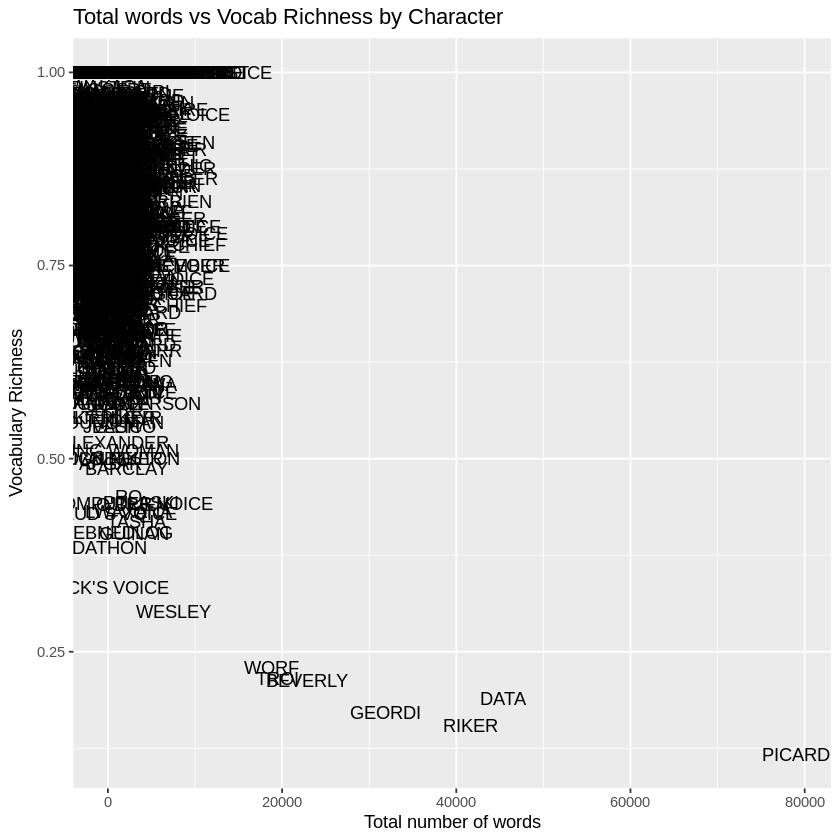

In [65]:
ggplot(unique_words, aes(x = total_words, y=richness, label = character)) +
  geom_text() +
  theme(legend.position = "none") +
  labs(x = "Total number of words", y = "Vocabulary Richness", title = "Total words vs Vocab Richness by Character")

#### d) Interpret these results.

The main characters tend to have less vocab richness than more minor characters on this plot. This lines up with what we know, since characters that have many more lines can be expected to use the same words more times than characters with few lines.

## Question 4
#### a) Find what episode Wesley left the show as a main character and state it explicitly. Meaning, find the first significant gap where he is not found in more than two episodes in a row.
*Hint*: It's after season 3 (ended at episode 174), so you can filter out seasons 1-3 and print Wesley's dialog count per episode. Then, scan the table for the gap.

In [66]:
dialogs_wes <- dialogs |>
  filter(character=="WESLEY", (episode_number >= 175))

episode_means_wes <- dialogs_wes|>
  group_by(episode_number) |>
  summarize(mean_dialog_length = mean(str_length(dialog)), .groups = "drop")

episode_means_wes

episode_number,mean_dialog_length
<dbl>,<dbl>
175,36.38889
176,66.50000
177,53.55556
178,18.66667
179,49.97368
181,45.00000
183,52.17021
206,46.90076
219,53.56338


Wesley stops being a main character after episode 183 (in and beyond episode 184, he does not appear for the first time for 2 consecutive episodes)

#### b) After Wesley leaves the main cast, in which episodes does he make cameo appearances?

Wesley makes cameo appearances in episodes 206, 219, 263, and 272

#### c) Dig back into the data. Print:
-   Wesley's last piece of dialog before he left the main cast.
-   Wesley's last piece of dialog ever.  
  
*Hint*: To do this, you'll need to filter the `dialogs_fixed` data set to Welsey's lines and the episode number, and use `slice_tail(n = 1)` to get the last observation.

In [67]:
last_dialogue <- dialogs_fixed |>
  filter(character == "WESLEY", episode_number == 183 ) |>
  slice_tail(n = 1)

last_line <- dialogs_fixed |>
  filter(character == "WESLEY", episode_number == 272) |>
  slice_tail(n = 1)

last_dialogue <- last_dialogue |>
  rbind(last_line)

last_dialogue

episode_number,character,dialog,dialog_length
<dbl>,<chr>,<chr>,<int>
183,WESLEY,I can walk.,11
272,WESLEY,"Good-bye, Mom.",14


Wesley's last line of dialogue before he left the main cast is "I can walk" and his last line ever is "Good-bye, Mom"

## Question 5
Create a heatmap with `dialog_len_per_ep` showing mean dialog length per episode for each character. Sort the characters on the y-axis by their overall mean dialog length, with the lowest on top using a factor. Add a title and an axis title.
*Hints*:
For the factor:
1. Compute overall mean (mean of mean) dialog length per character (`group_by()` then `summarize()`), and arrange the overall mean in ascending order. Add `pull(character)` to the end of this step so that you can use character as a factor in the next step. Store all of this in a new tibble.
2. Convert character to factor with this order. On `dialog_len_per_ep`, you'll use a mutate statement to add the factor `(mutate(character = factor(character, levels = DATAFROMHINT1))`.
3. Create heatmap using `geom_tile()`.
4. If you want nicer colors, you can add `scale_fill_viridis_c()` (or another color scale) to your ggplot statement. **Not required**, but fun to mess around with!

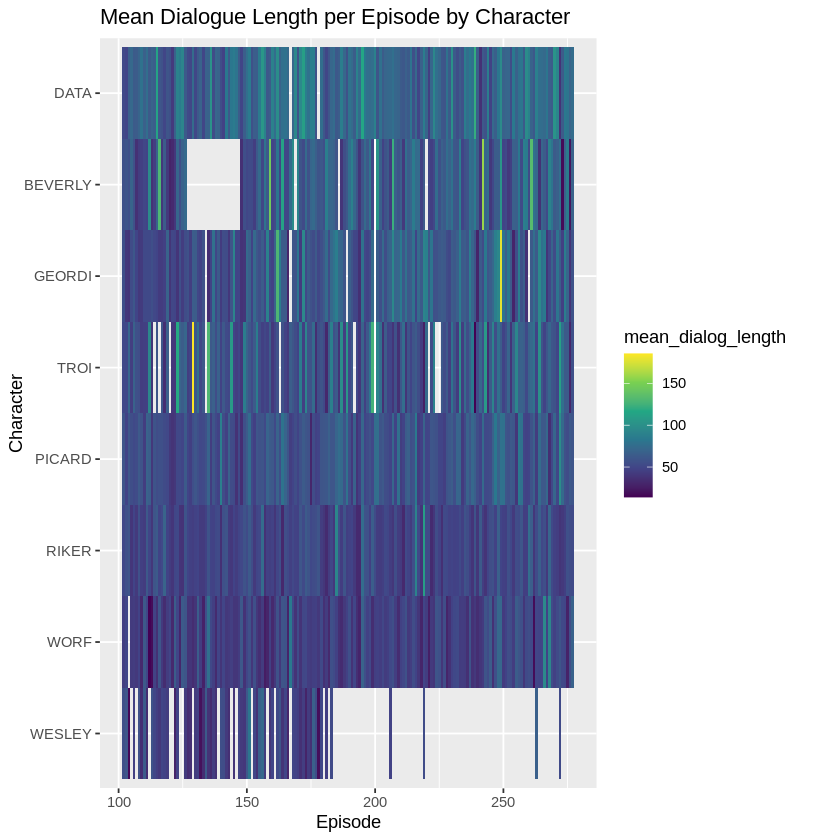

In [71]:
character_dialogues <- dialogs |>
  group_by(character, episode_number) |>
  summarize(mean_dialog_length = mean(str_length(dialog)), .groups = "drop") |>
  group_by(character) |>
  summarize(mean_dialog_len_per_ep = mean(mean_dialog_length), .groups="drop") |>
  arrange(mean_dialog_len_per_ep) |>
  pull(character)

dialog_len_per_ep <- dialog_len_per_ep |>
  mutate(character = factor(character, levels = character_dialogues))

ggplot(dialog_len_per_ep, aes(x = episode_number, y = character, fill = mean_dialog_length)) +
  geom_tile() +
  scale_fill_viridis_c() +
  labs(
    title = "Mean Dialogue Length per Episode by Character",
    x = "Episode",
    y = "Character"
  )
